In [4]:
import pandas as pd
import numpy as np
import random
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
# from tqdm import tqdm
import gudhi as gd


In [5]:
# print("Loading the dataset...")
df = pd.read_csv(r"../data/preprocessed_data.csv")
# print(f"Original dataset loaded with {len(df)} records.")

# Log the intention to sample
# print("Attempting to sample 1000 records with replacement...")
try:
    df_sampled = df.sample(n=10000, replace=True)  # Allows sampling the same row more than once
    # print(f"Sampled dataset created with {len(df_sampled)} records.")
except ValueError as e:
    print(f"Error: Not enough records to sample with replacement: {e}")
    exit()

In [6]:
# ga_type = input("Enter GA type (generic (1) or proposed (2)): ").strip()
ga_type = "1"

if ga_type not in ['1', '2']:
    raise ValueError("Invalid GA type. Please enter '1' for generic or '2' for proposed.")


# GENERIC GENETIC ALGO


In [7]:
def split_timeslot(timeslot):
    parts = timeslot.split(' ')
    if len(parts) >= 2:
        return parts[0], ' '.join(parts[1:])
    return timeslot, ''  # Adjust this according to the expected format

df_sampled['day'], df_sampled['time'] = zip(*df_sampled['timeslot'].apply(split_timeslot))
df_sampled['start_time'], df_sampled['end_time'] = zip(*df_sampled['time'].apply(lambda x: x.split('-') if x else ('', '')))

In [8]:
class Schedule:
    # Class variable to track all occupied timeslots
    occupied_timeslots = set()

    def __init__(self, assignments, teacher_type, ga_type, max_hours=None, unavailable_days=None, location_to_index_map=None):
        self.assignments = assignments
        self.teacher_type = teacher_type
        self.ga_type = ga_type
        self.max_hours = max_hours
        self.unavailable_days = unavailable_days or []
        self.location_to_index_map = location_to_index_map

    def update_occupied_timeslots(self):
        for a in self.assignments:
            Schedule.occupied_timeslots.add((a['faculty'], a['timeslot']))

    def is_timeslot_available(self, faculty, timeslot):
        return (faculty, timeslot) not in Schedule.occupied_timeslots

    def __str__(self):
        schedule_details = "Schedule:\n"
        for assignment in self.assignments:
            schedule_details += f"Course: {assignment['course']}, Faculty: {assignment['faculty']}, Timeslot: {assignment['timeslot']}, Classroom: {assignment['classroom']}\n"
        return schedule_details

    def fitness(self):
        if self.ga_type == '1':
            return self.generic_fitness_evaluation()
        elif self.ga_type == '2':
            return self.tda_based_fitness_evaluation()
        else:
            # print(f"Unexpected GA type encountered in fitness evaluation: {self.ga_type}")
            return 0  # Or handle as appropriate


    def generic_fitness_evaluation(self):
        # Initialize variables
        total_hours = 0
        faculty_course_count = {}
        penalty = 0

        for a in self.assignments:
            # print("== Inside (for a in self.assignments loop) ==")

            # print(f"a: {a}")

            duration = self.calculate_duration(a['start_time'], a['end_time'])
            # print(f"duration: {duration}")

            total_hours += duration
            # print(f"total_hours: {total_hours}")

            faculty_course_count[a['faculty']] = faculty_course_count.get(a['faculty'], 0) + 1
            # print(f"faculty_course_count: {faculty_course_count}")


        # print(f"1 total_hours: {total_hours}")
        # print(f"2 faculty_course_count: {faculty_course_count}")

        # Calculate penalties
        # Overloading Faculty
        if self.teacher_type == 'FT' and total_hours > self.max_hours:
            penalty += 10

        # Part-time Faculty
        if self.teacher_type == 'PT' and total_hours > 12:
            penalty += 7

        # Inequitable Course Distribution
        print(f"faculty_course_count: {faculty_course_count}")
        # faculty_course_count: {'FT6': 2, 'PT1': 3, 'PT4': 2, 'FT2': 1, 'FT3': 1, 'FT1': 1}

        # Check if distribution is inequitable
        if len(faculty_course_count) > 1:
            max_courses = max(faculty_course_count.values())
            min_courses = min(faculty_course_count.values())
            error_percentage = (max_courses - min_courses) / max_courses

            if error_percentage > 0.1:
                penalty += int(error_percentage * 10)  # Adjust the penalty based on the error percentage

        # Consulting Hours Overlap
        for i in range(len(self.assignments)):
            for j in range(i + 1, len(self.assignments)):
                if self.assignments[i]['faculty'] == self.assignments[j]['faculty'] and \
                        self.assignments[i]['timeslot'] == self.assignments[j]['timeslot']:
                    penalty += 5
                    break

        # Faculty Preferences Ignored
        for a in self.assignments:
            if a['day'] in self.unavailable_days:
                penalty += 4

        # Classroom Utilization Inefficiency - Underutilized or overutilized classrooms
        classroom_usage = {}
        for a in self.assignments:
            classroom_usage[a['classroom']] = classroom_usage.get(a['classroom'], 0) + self.calculate_duration(a['start_time'], a['end_time'])

        for classroom, usage in classroom_usage.items():
            if usage < 3:
                penalty += 3
            elif usage > 5:
                penalty += 3

        # Student Schedule Clashes
        for i in range(len(self.assignments)):
            for j in range(i + 1, len(self.assignments)):
                if self.assignments[i]['timeslot'] == self.assignments[j]['timeslot'] and \
                        self.assignments[i]['classroom'] == self.assignments[j]['classroom']:
                    penalty += 2
                    break

        # Compute fitness score and subtract penalties
        fitness_score = 1 / (1 + penalty)

        print(f"4 fitness_score (Must not stay on same values always): {fitness_score}")

        return fitness_score



    def tda_based_fitness_evaluation(self):
        # print("1 Inside tda_based_fitness_evaluation")

        # Invoking to_point_cloud() method
        # print("2 Invoking to_point_cloud() method")
        point_cloud = self.to_point_cloud(self.location_to_index_map)
        # print("3 point_cloud: ", point_cloud)

        # Invoking compute_persistence_diagrams() method, receives point_cloud as parameter
        # print("4 Invoking compute_persistence_diagrams() method")
        persistence_diagrams = compute_persistence_diagrams(point_cloud)
        # print("5 persistence_diagrams: ", persistence_diagrams)

        return compute_tda_fitness(persistence_diagrams)


    def to_point_cloud(self, location_to_index_map):
        point_cloud = []
        for assignment in self.assignments:
            time_float = self.convert_time_to_float(assignment['start_time'])
            classroom_index = self.convert_location_to_index(assignment['classroom'], location_to_index_map)
            point_cloud.append((time_float, classroom_index))
        return point_cloud


    @staticmethod
    def calculate_duration(start, end):
        def parse_time(time_str):
            time_str = time_str.strip()
            if ' PM' in time_str or ' AM' in time_str:
                time_str = time_str[:time_str.rfind(' ')]
            for fmt in ('%I:%M %p', '%H:%M'):
                try:
                    return datetime.strptime(time_str, fmt)
                except ValueError:
                    continue
            raise ValueError(f"Time data '{time_str}' does not match expected format")

        start_time, end_time = parse_time(start), parse_time(end)
        if end_time < start_time:
            end_time += timedelta(days=1)

        return (end_time - start_time).total_seconds() / 3600.0 # In hours

    @staticmethod
    def convert_time_to_float(time_str):
        # Map each day to a number (e.g., Monday=0, Tuesday=1, etc.)
        day_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

        # Split the time string into day and time of day (if day is provided)
        parts = time_str.strip().split(maxsplit=1)
        day_part = parts[0] if len(parts) == 2 else "Monday"  # Default to Monday if day is not provided
        time_of_day = parts[-1]

        day_num = day_to_num.get(day_part, 0)  # Default to 0 if day is not found

        # Convert time to total hours
        time_format = "%H:%M"
        time_delta = datetime.strptime(time_of_day, time_format) - datetime.strptime("00:00", time_format)
        total_hours = 24 * day_num + time_delta.total_seconds() / 3600

        return total_hours



    @staticmethod
    def convert_location_to_index(location_str, location_to_index_map):
        # Assuming location_to_index_map is a pre-defined dictionary mapping locations to unique integers
        return location_to_index_map.get(location_str, -1)  # Return -1 or some default value if location is not found


# NOTE: Slows down inside compute_persistence_diagrams() method
# TDA-related functions
def compute_persistence_diagrams(point_cloud):
    # print("1 Inside compute_persistence_diagrams()")

    # print("2 Invoking gd.AlphaComplex()")
    alpha_complex = gd.AlphaComplex(points=point_cloud)
    # print(f"3 alpha_complex: {alpha_complex}")

    # print("4 Invoking alpha_complex.create_simplex_tree()")
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=42)
    # print(f"5 simplex_tree: {simplex_tree}")

    # print("6 Invoking simplex_tree.persistence()")
    persistence = simplex_tree.persistence()
    # print(f"7 persistence: {persistence}")

    persistence_diagrams = []

    for i in range(len(persistence)):
        if persistence[i][1] != float('inf'):
            persistence_diagrams.append(persistence[i])

    # print(f"8 persistence_diagrams: {persistence_diagrams}")

    return persistence_diagrams


def compute_tda_fitness(persistence_diagrams):
    return sum(persistence[1] - persistence[0] for persistence in persistence_diagrams if persistence[1] != float('inf'))


In [9]:
# Initialize population
def initialize_population(size, df, teacher_type, max_hours, unavailable_days, location_to_index_map):
    population = []
    for _ in range(size):
        assignments = df.sample(n=10).to_dict('records')
        population.append(Schedule(assignments, teacher_type, '1', max_hours, unavailable_days, location_to_index_map))

    print(f"== population len: {len(population)} | size: {size} ==")   
    return population




In [10]:
def select_parents(population):
    # Sort the population by fitness in descending order and assign ranks
    sorted_population = sorted(population, key=lambda x: x.fitness(), reverse=True)
    
    # Calculate selection probabilities based on ranks
    total_ranks = sum(range(1, len(population) + 1))  # Sum of ranks
    selection_probabilities = [rank / total_ranks for rank in range(len(population), 0, -1)]

    # Select parents
    parents = []
    for _ in range(len(population)):
        chosen_parent = random.choices(sorted_population, weights=selection_probabilities, k=1)[0]
        parents.append(chosen_parent)
        # print(f"Parent selected with fitness: {chosen_parent.fitness()}")

    return parents


In [11]:
# crossover
def enhanced_crossover(parent1, parent2, teacher_type, max_hours, unavailable_days):
        """
        Performs enhanced crossover between two parent schedules. Crossover is performed by selecting two random crossover.

        Parameters:
        - parent1 (Schedule): The first parent schedule.
        - parent2 (Schedule): The second parent schedule.
        - teacher_type (str): The type of teacher (FT or PT).
        - max_hours (int): The maximum number of hours for full-time teachers.
        - unavailable_days (list): The list of unavailable days for faculty.

        Returns:
        - child (Schedule): The child schedule generated from crossover.
        """

        # Select two random crossover points
        crossover_point1 = random.randint(1, len(parent1.assignments) - 2)
        crossover_point2 = random.randint(crossover_point1 + 1, len(parent1.assignments) - 1)

        new_assignments = parent1.assignments[:crossover_point1] + parent2.assignments[crossover_point1:crossover_point2] + parent1.assignments[crossover_point2:]
        child = Schedule(new_assignments, teacher_type, ga_type, max_hours, unavailable_days)

        return child


In [12]:
# Mutation
def mutate(schedule):
    mutation_rate = 0.1
    if random.random() < mutation_rate:
        mutated_assignment = df_sampled.sample(1).to_dict('records')[0]
        schedule.assignments[random.randint(0, len(schedule.assignments) - 1)] = mutated_assignment
        # print(f"Mutation occurred with new assignment: {mutated_assignment}")
    return schedule

In [13]:
# Elitism
def elitism(population, top_k=1):
    return sorted(population, key=lambda s: s.fitness(), reverse=True)[:top_k]

# PROPOSED GA

In [14]:
def logistic_map(r, x):
    """Logistic map function."""
    return r * x * (1 - x)

def chaotic_initial_population(size, df, teacher_type, max_hours, unavailable_days, location_to_index_map):
    """Generate initial population with chaotic mapping based on the logistic map."""
    r = 3.99  # Chaotic regime for logistic map
    x = 0.5  # Arbitrary start value in (0, 1)
    population = []

    # Sample a sufficient number of rows from df
    x = logistic_map(r, x)
    raw_sample_size = int(x * len(df))  # Calculate raw sample size
    sample_size = min(raw_sample_size, len(df))  # Ensure sample size does not exceed the length of df
    sampled_df = df.sample(n=sample_size).to_dict('records')  # Convert to list of dictionaries

    # Create Schedule instances
    for i in range(size):
        assignments = sampled_df[i*size:(i+1)*size]  # Get the assignments for the current individual
        schedule = Schedule(assignments, teacher_type, '2', max_hours, unavailable_days, location_to_index_map)  # Pass '2' for proposed GA
        population.append(schedule)

    return population

In [15]:

# NOTE: Slows down inside compute_persistence_diagrams() method
# Implement TDA analysis using Gudhi
def compute_persistence_diagrams(point_cloud):
    # print(f"0 Point Cloud: {point_cloud}")

    # print("1 Inside compute_persistence_diagrams()")

    # print("2 Invoking gd.AlphaComplex()")
    alpha_complex = gd.AlphaComplex(points=point_cloud)
    """
        Alpha complex is a simplicial complex associated to a finite set of points in a metric space. 
        It is constructed by attaching tetrahedra to the points in such a way that the tetrahedra associated to nearby points fit together.
    """
    # print(f"3 alpha_complex: {alpha_complex}")

    # print("4 Invoking alpha_complex.create_simplex_tree()")
    simplex_tree = alpha_complex.create_simplex_tree()
    # print(f"5 simplex_tree: {simplex_tree}")

    # print("6 Invoking simplex_tree.persistence()")
    persistence = simplex_tree.persistence()
    # print(f"7 persistence: {persistence}")
    
    persistence_diagrams = []

    for p in persistence:
        if p[0] == 0:
            continue
        persistence_diagrams.append(p)

    # print(f"8 persistence_diagrams: {persistence_diagrams}")

    return persistence_diagrams


In [16]:
def check_termination_condition(population, generation, max_generations, target_fitness, convergence_threshold):
    """
    Check if the termination condition for the genetic algorithm is met.

    :param population: The current population of schedules.
    :param generation: The current generation number.
    :param max_generations: The maximum number of generations to run.
    :param target_fitness: The target fitness score to achieve.
    :param convergence_threshold: The threshold for population convergence.

    :return: True if the termination condition is met, False otherwise.
    """

    # Print params for checking
    # print(f"(Inside Check Termination Condition) Generation: {generation}, max_generations: {max_generations}, target_fitness: {target_fitness}, convergence_threshold: {convergence_threshold}")

    # Check if the maximum number of generations has been reached
    if generation >= max_generations:
        # print(f"1 Terminated at (generation >= max_generations) | {generation} >= {max_generations}")

        return True

    # Check if any individual in the population has reached the target fitness
    if any(schedule.fitness() >= target_fitness for schedule in population):
        print(f"2 Terminated at (any(schedule.fitness() >= target_fitness for schedule in population)) | {any(schedule.fitness() >= target_fitness for schedule in population)}")

        return True

    # print(f"Populations: ${population}")

    # # Check for population convergence
    # # fitness_values = [schedule.fitness() for schedule in population]

    # fitness_values = []

    # # Loop through population and get the fitness values instead of one line
    # for schedule in population:
    #     print(f"(Inside a loop in population) Schedule: {schedule}")
    #     print(f"(Inside a loop in population) Fitness: {schedule.fitness()}")
    #     print(f"(Inside a loop in population) Fitness Values: {fitness_values}")

    #     fitness_values.append(schedule.fitness())

    # if max(fitness_values) - min(fitness_values) < convergence_threshold:

    #     print(f"Fitness Values: ${fitness_values}")

    #     print(f"Max Fitness Values: {max(fitness_values)}")
    #     print(f"Min Fitness Values: {min(fitness_values)}")

    #     print(f"Convergence Threshold: {convergence_threshold}")

    #     print(f"3 Terminated at (max(fitness_values) - min(fitness_values) < convergence_threshold) | {max(fitness_values) - min(fitness_values) < convergence_threshold}")

    #     return True
    
    # print("4 Continuing...")

    # If none of the above conditions are met, continue the algorithm
    return False


In [17]:
def check_convergence_with_enhanced_criteria(population, fitness_threshold, diversity_threshold, improvement_threshold, num_generations_for_improvement_check):
    # print(f"Inside check_convergence_with_enhanced_criteria | Population: {population} | Fitness Threshold: {fitness_threshold} | Diversity Threshhold: {diversity_threshold} | Improvement Threshold: {improvement_threshold} | Num Generations For Improvement Check: {num_generations_for_improvement_check}")
    
    # Check if any individual exceeds the fitness threshold
    if any(individual.fitness() >= fitness_threshold for individual in population):
        return True

    # Calculate diversity (could be based on genetic diversity or variance in fitness)
    fitness_values = [individual.fitness() for individual in population]
    diversity = calculate_diversity(fitness_values)  # Implement this function

    # Check if diversity is too low
    if diversity < diversity_threshold:
        return True

    # Check improvement rate (implement a way to track fitness over generations)
    if len(fitness_values) > num_generations_for_improvement_check:
        recent_fitness_values = fitness_values[-num_generations_for_improvement_check:]
        improvement = max(recent_fitness_values) - min(recent_fitness_values)
        if improvement < improvement_threshold:
            return True

    return False

def calculate_diversity(fitness_values):
    # Implement a method to calculate diversity.
    # For example, using standard deviation as a measure of diversity
    return np.std(fitness_values)

In [18]:
def de_crossover_and_mutation(parent1, parent2, population, F=0.8, CR=0.5):
    # Select two random individuals from the population for differential mutation
    individual1, individual2 = random.sample(population, 2)

    # DE Trial Vector Creation
    trial_vector = {}
    for key in parent1.assignments:
        base_value = parent1.assignments[key]
        trial_vector[key] = base_value + F * (individual1.assignments[key] - individual2.assignments[key])

    # DE Crossover Operation
    child_assignments = {}
    for key in parent1.assignments:
        if random.random() < CR:
            child_assignments[key] = trial_vector[key]
        else:
            child_assignments[key] = parent1.assignments[key]

    # Create child with new assignments
    # child = Schedule(child_assignments, parent1.teacher_type, parent1.ga_type, parent1.max_hours, parent1.unavailable_days)
    child = Schedule(child_assignments, parent1.teacher_type, ga_type, parent1.max_hours, parent1.unavailable_days)

    # Mutation (optional, depending on your design)
    child = mutate(child)  # Assuming 'mutate' is a predefined function

    return child


In [19]:
def dynamic_parameter_adjustment_with_tda(schedule, population, feature_persistence_threshold, location_to_index_map):
    # print("1 Inside dynamic_parameter_adjustment_with_tda()")

    # Convert the population to a point cloud for TDA
    point_cloud = []
    for individual in population:
        individual_cloud = individual.to_point_cloud(location_to_index_map)
        point_cloud.extend(individual_cloud)  # Flatten the structure by extending the main point cloud

    # print(f"2 Point Cloud: {point_cloud}")

    # Perform TDA on the point cloud
    persistence_diagrams = compute_persistence_diagrams(point_cloud)

    # print(f"3 Persistence Diagrams: {persistence_diagrams}")

    # Analyze the persistence diagrams
    analysis_result = analyze_persistence_diagrams(persistence_diagrams, feature_persistence_threshold)

    # print(f"4 Analysis Result: {analysis_result}")

    # Adjust parameters based on TDA analysis
    if analysis_result['indicates_convergence']:
        # print("5 Analysis Result indicates convergence")

        # Increase mutation rate to maintain diversity
        schedule.mutation_rate = min(schedule.mutation_rate + 0.05, 1.0)

        # print(f"6 Schedule Mutation Rate: {schedule.mutation_rate}")

    elif analysis_result['indicates_diversity']:
        # print("7 Analysis Result indicates diversity")

        # Decrease mutation rate
        schedule.mutation_rate = max(schedule.mutation_rate - 0.05, 0.01)

        # print(f"8 Schedule Mutation Rate: {schedule.mutation_rate}")

    return schedule



def analyze_persistence_diagrams(persistence_diagrams, feature_persistence_threshold):
    # Define thresholds for convergence and diversity
    CONVERGENCE_THRESHOLD = 10  # Example value indicating a high level of population complexity
    DIVERSITY_THRESHOLD = 5     # Example value indicating a low level of population complexity

    # Count significant features in persistence diagrams
    num_significant_features = len([d for d in persistence_diagrams if d[1] - d[0] > feature_persistence_threshold])

    # Determine population structure based on significant features
    analysis_result = {
        'indicates_convergence': num_significant_features > CONVERGENCE_THRESHOLD,
        'indicates_diversity': num_significant_features < DIVERSITY_THRESHOLD,
    }

    return analysis_result


In [20]:
def select_best_solution(population):
    # Select the individual with the highest fitness score in the population
    best_individual = max(population, key=lambda individual: individual.fitness())
    return best_individual


In [21]:
def plot_fitness_scores(fitness_scores, title):
    plt.plot(fitness_scores)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title(title)
    plt.show()

# GENERIC GA FUNCTION

In [22]:
target_fitness = 95  # This means we are aiming for a solution with at least a fitness of 95
convergence_threshold = 0.5  # This means we consider the algorithm to have converged if the improvement is less than 0.5

def generic_GA(population_size, max_generations, df, teacher_type, max_hours=None, unavailable_days=None):
    # Print parameters for tracking
    print(f"Population size: {population_size}, max generations: {max_generations}, teacher type: {teacher_type}, max hours: {max_hours}, unavailable days: {unavailable_days}")

    # Define the mapping from classroom locations to indices
    location_to_index_map = {classroom: index for index, classroom in enumerate(df['classroom'].unique(), start=1)}

    # Initialize population
    population = initialize_population(population_size, df, teacher_type, max_hours, unavailable_days, location_to_index_map)

    fitness_scores = []  # List to store the best fitness score in each generation

    # Main GA loop
    for generation in range(max_generations):
        # Append the best fitness score in the current generation, inside population.fitnes()
        generation_best_fitness_without_max = [individual.fitness() for individual in population] # May 1.0 sa loob ng list na 'to, have to fix fitness. Masyadong unrealistic
        print(f"Generation Best Fitness Without Max: {generation_best_fitness_without_max} | generation_best_fitness_without_max len {len(generation_best_fitness_without_max)}")

        generation_best_fitness = max(individual.fitness() for individual in population)
        print(f"Generation Best Fitness: {generation_best_fitness}")

        fitness_scores.append(generation_best_fitness)

        print(f"Fitness Scores: {fitness_scores}")

        # Check termination condition
        if check_termination_condition(population, generation, max_generations, target_fitness, convergence_threshold):
            print(f"Termination condition met at generation {generation}.")
            break
        
        # Select parents -- under select_parents() function
        print(f"Selecting parents for generation {generation}...")

        # Sort the population by fitness in descending order and assign ranks
        sorted_population = sorted(population, key=lambda x: x.fitness(), reverse=True)
        
        # Calculate selection probabilities based on ranks
        total_ranks = sum(range(1, len(population) + 1))  # Sum of ranks
        selection_probabilities = [rank / total_ranks for rank in range(len(population), 0, -1)]
        print(f"Selection Probabilities: {selection_probabilities}")

        # Get sorted population in an array of their fitness values
        sorted_population_fitness = [individual.fitness() for individual in sorted_population]
        print(f"Sorted Population Fitness: {sorted_population_fitness}")
        

        # Select parents ---
        parents = []
        for _ in range(len(population)):
            chosen_parent = random.choices(sorted_population, weights=selection_probabilities, k=1)[0]
            parents.append(chosen_parent)
            # print(f"Parent selected with fitness: {chosen_parent.fitness()}")

        # Loop through parents and print their fitness
        for parent in parents:
            print(f"Parent Fitness: {parent.fitness()}")

        # ---

        # Generate offspring through crossover, handling odd number of parents ---
        children = []
        
        for i in range(0, len(parents), 2):
            # Check if the next parent exists
            if i + 1 < len(parents): # If the next parent exists
                # Print 2 parents and their fitness
                print(f"Parent 1: {parents[i]} | Parent 1 Fitness: {parents[i].fitness()}")
                print(f"Parent 2: {parents[i+1]} | Parent 2 Fitness: {parents[i+1].fitness()}")

                child = enhanced_crossover(parents[i], parents[i+1], teacher_type, max_hours, unavailable_days)

                # Print the child and its fitness
                print(f"Child: {child} | Child Fitness: {child.fitness()}")

                children.append(child)
            else: # Handle the case where the number of parents is odd
                # Example: Pair the last parent with the first parent
                child = enhanced_crossover(parents[i], parents[0], teacher_type, max_hours, unavailable_days)
                children.append(child)

        # ---

        # Mutate the offspring
        for child in children:
            mutate(child)

        # Apply elitism to form the next generation, this preserves the best individuals
        elite = elitism(population)
        population = children + elite

        # Loop through population and print their fitness
        for individual in population:
            print(f"1 Individual Fitness: {individual.fitness()}")

        # Logging for tracking
        print(f"Generation {generation}: Best fitness score: {generation_best_fitness}")

    # Find the best solution from the final population
    best_solution = max(population, key=lambda ind: ind.fitness())

    # Plot the evolution of fitness scores
    plt.plot(fitness_scores)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('Generic Genetic Algorithm Progress')
    plt.show()

    return best_solution


In [23]:
def proposed_GA(population_size, max_generations, df, teacher_type, max_hours=None, unavailable_days=None, feature_persistence_threshold=0.1):
    # print("Initializing proposed GA...")
    
    # Log the initial parameters
    # print(f"Parameters: Population size: {population_size}, Max generations: {max_generations}, Teacher type: {teacher_type}, Max hours: {max_hours}, Unavailable days: {unavailable_days}")

    # Define the mapping from classroom locations to indices
    location_to_index_map = {classroom: index for index, classroom in enumerate(df['classroom'].unique(), start=1)}
    # print(f"Classroom location to index mapping: {location_to_index_map}")

    # Initialize population with chaotic mapping
    # print("Initializing population with chaotic mapping...")

    # NOTE: Reaches 1 min here, this is slow.
    population = chaotic_initial_population(population_size, df, teacher_type, max_hours, unavailable_days, location_to_index_map)

    # print(f"Initial population size: {len(population)}")

    # Define thresholds
    # print("Defining fitness, convergence, and diversity thresholds...")
    
    fitness_scores = []  # List to store the best fitness score in each generation

    # Main GA loop
    for generation in range(max_generations):
        # print(f"\n1 Starting generation {generation}...")

        # Evaluate fitness with TDA guidance for each individual
        for individual in population:

            # NOTE: Slows down here that's why it is stucked in generation 0, I'll check individual.fitness()

            individual.fitness()  # Calls the TDA-based fitness evaluation

        # print(f"\n2 Evaluated fitness for generation {generation}...")

        # Log the best fitness score in this generation
        generation_best_fitness = max(individual.fitness() for individual in population)

        # print(f"\n3 Calculated generation best fitness for generation {generation}...")

        fitness_scores.append(generation_best_fitness)

        # print(f"\n4 Appended generation best fitness for generation {generation}...")
        # print(f"5 Generation {generation}: Best fitness score: {generation_best_fitness}")

        # Check termination condition
        if check_termination_condition(population, generation, max_generations, target_fitness, convergence_threshold):
            # print(f"6 Termination condition met at generation {generation}.")
            break

        # Select parents
        # print("Selecting parents...")
        parents = select_parents(population)
        # print(f"Number of parents selected: {len(parents)}")

        fitness_threshold = 1
        diversity_threshold = 1
        improvement_threshold = 1
        num_generations_for_improvement_check = 100

        # Initialize children as an empty list
        children = []

        # Apply DE-Inspired crossover and mutation or dynamic parameter adjustment based on convergence
        # print("Applying crossover and mutation...")
        if not check_convergence_with_enhanced_criteria(population, fitness_threshold, diversity_threshold, improvement_threshold, num_generations_for_improvement_check):
            # print("Applying DE-Inspired crossover and mutation...")
            children = [de_crossover_and_mutation(parents[i], parents[i+1], population) for i in range(0, len(parents), 2)]
            # print(f"Number of children generated: {len(children)}")
        else:
            # print("Applying dynamic parameter adjustment...")
            children = [dynamic_parameter_adjustment_with_tda(child, population, feature_persistence_threshold, location_to_index_map) for child in children]
            # print(f"Number of children generated: {len(children)}")

        # Combine elite individuals from the previous generation with offspring
        elite = elitism(population)
        # print(f"Number of elite individuals: {len(elite)}")
        population = children + elite

    # Find the best solution from the final population
    best_solution = select_best_solution(population)
    # print("\nBest solution found:")
    # print(best_solution)

    # Plot the evolution of fitness scores
    plt.plot(fitness_scores)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('Proposed Genetic Algorithm Progress')
    plt.show()

    return best_solution


In [24]:
# teacher_type = input("Enter teacher type (FT for Full-Time, PT for Part-Time): ").strip()
teacher_type = "FT"

max_hours = None
unavailable_days = []

if teacher_type == 'FT':
    # max_hours = float(input("Enter maximum hours you can teach per week: "))
    max_hours = 30.0
elif teacher_type == 'PT':
    # unavailable_days = input("Enter unavailable days (comma-separated, e.g., Monday,Wednesday): ").split(',')
    unavailable_days =  "Monday,Wednesday".split(',')


Population size: 100, max generations: 500, teacher type: FT, max hours: 30.0, unavailable days: []
== population len: 100 | size: 100 ==
faculty_course_count: {'FT4': 1, 'FT6': 2, 'FT2': 2, 'FT3': 3, 'PT1': 1, 'FT5': 1}
4 fitness_score (Must not stay on same values always): 0.03225806451612903
faculty_course_count: {'FT3': 2, 'FT4': 2, 'FT1': 2, 'PT4': 2, 'PT1': 1, 'FT5': 1}
4 fitness_score (Must not stay on same values always): 0.025
faculty_course_count: {'PT4': 3, 'FT6': 1, 'FT4': 1, 'FT3': 2, 'PT1': 2, 'FT1': 1}
4 fitness_score (Must not stay on same values always): 0.03225806451612903
faculty_course_count: {'FT3': 2, 'PT4': 6, 'FT6': 1, 'FT2': 1}
4 fitness_score (Must not stay on same values always): 0.037037037037037035
faculty_course_count: {'PT4': 2, 'FT5': 2, 'FT3': 2, 'FT1': 1, 'FT4': 1, 'PT1': 1, 'FT2': 1}
4 fitness_score (Must not stay on same values always): 0.041666666666666664
faculty_course_count: {'FT4': 4, 'FT2': 1, 'FT6': 2, 'PT1': 1, 'FT5': 1, 'FT1': 1}
4 fitness_s

4 fitness_score (Must not stay on same values always): 0.03571428571428571
faculty_course_count: {'FT3': 2, 'FT4': 5, 'PT1': 1, 'FT1': 1, 'PT4': 1}
4 fitness_score (Must not stay on same values always): 0.037037037037037035
faculty_course_count: {'FT1': 3, 'FT3': 2, 'FT5': 1, 'FT2': 1, 'PT4': 1, 'PT1': 2}
4 fitness_score (Must not stay on same values always): 0.03225806451612903
faculty_course_count: {'FT4': 4, 'FT5': 3, 'FT1': 1, 'FT3': 1, 'PT4': 1}
4 fitness_score (Must not stay on same values always): 0.05
faculty_course_count: {'PT1': 2, 'FT4': 1, 'FT5': 2, 'FT3': 1, 'FT2': 2, 'FT1': 1, 'FT6': 1}
4 fitness_score (Must not stay on same values always): 0.041666666666666664
faculty_course_count: {'PT1': 1, 'FT1': 1, 'FT5': 2, 'FT2': 2, 'FT3': 1, 'FT4': 2, 'PT4': 1}
4 fitness_score (Must not stay on same values always): 0.037037037037037035
faculty_course_count: {'PT1': 3, 'PT4': 1, 'FT4': 1, 'FT6': 1, 'FT1': 1, 'FT2': 2, 'FT5': 1}
4 fitness_score (Must not stay on same values always):

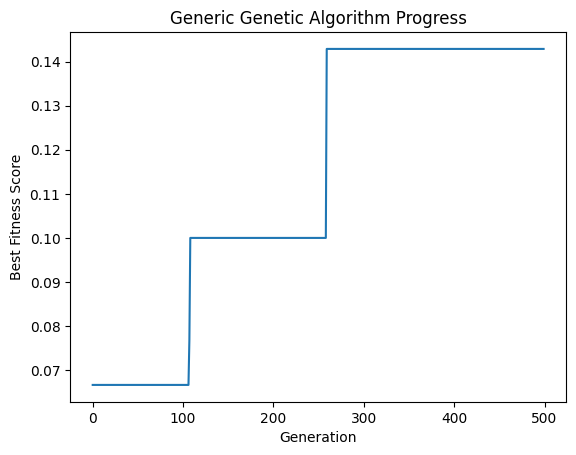

faculty_course_count: {'FT6': 2, 'FT2': 2, 'FT4': 2, 'PT1': 2, 'FT3': 2}
4 fitness_score (Must not stay on same values always): 0.14285714285714285
Best schedule fitness: 0.14285714285714285
Best Schedule Details:
 Schedule:
Course: CSC 0102, Faculty: FT6, Timeslot: Thursday 2:00 - 3:00 PM, Classroom: GV 302
Course: CSC 0102, Faculty: FT2, Timeslot: Tuesday 8:00 - 9:00 AM, Classroom: Com Lab 4
Course: CSC 0102, Faculty: FT4, Timeslot: Saturday 1:00 - 2:00 PM, Classroom: GV 305
Course: CSC 0311, Faculty: PT1, Timeslot: Wednesday 11:00 - 12:00 AM, Classroom: GV 305
Course: CSC 0102, Faculty: FT6, Timeslot: Thursday 12:00 - 13:00 PM, Classroom: Com Lab 4
Course: CSC 0102, Faculty: FT2, Timeslot: Wednesday 12:00 - 13:00 PM, Classroom: GV 302
Course: CSC 0311, Faculty: PT1, Timeslot: Tuesday 9:00 - 10:00 AM, Classroom: GV 305
Course: CSC 0102, Faculty: FT3, Timeslot: Wednesday 7:00 - 8:00 AM, Classroom: GV 301
Course: CSC 0102, Faculty: FT3, Timeslot: Tuesday 8:00 - 9:00 PM, Classroom: Com 

In [25]:
def run_genetic_algorithm(ga_type, population_size, max_generations, df, teacher_type, max_hours=None, unavailable_days=None, feature_persistence_threshold=0.1):
    # Convert ga_type to string to ensure consistency in comparison
    ga_type = str(ga_type)
    
    if ga_type == '1':  # If generic GA is selected
        return generic_GA(population_size, max_generations, df, teacher_type, max_hours, unavailable_days)
    elif ga_type == '2':  # If proposed GA is selected
        return proposed_GA(population_size, max_generations, df, teacher_type, max_hours, unavailable_days, feature_persistence_threshold)
    else:
        raise ValueError(f"Encountered invalid GA type: {ga_type}")

# Define the parameters for the genetic algorithm
population_size = 100  # Set the population size as per your requirement
max_generations = 500    # Set the maximum number of generations


# Run the chosen genetic algorithm to find the best schedule
best_schedule_found = run_genetic_algorithm(ga_type, population_size, max_generations, df_sampled, teacher_type, max_hours, unavailable_days)

# Check if a schedule was found and print details
if best_schedule_found:
    print("Best schedule fitness:", best_schedule_found.fitness())
    print("Best Schedule Details:\n", best_schedule_found)
else:
    print("No suitable schedule was found.")
